### CAPSTONE: Predicting virus neutralization by antibodies using Neural Networks

#### Lilian Nogueira

In [75]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import defaultdict
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer


import warnings
warnings.filterwarnings('ignore')

In [76]:
# Loading the data

df_sorted_ic50 = pd.read_csv('df_ic50_final.csv')
df_sorted_ic50

,Antibody,Binding Type,Virus,Sequence,Neutralization
0,10-1074,gp120 V3 // V3 glycan (V3g),0013095_2_11,MRVKG-ILRNYQQW--------WIW--------SILGFW--MLMN-...,0
1,10-1074,gp120 V3 // V3 glycan (V3g),AIIMS706_70607F,MRVRG-IWRNYPQW--------WIW--------GVLG-----LLI-...,1
2,10-1074,gp120 V3 // V3 glycan (V3g),AIIMS709_70912B,MRVRG-TLRNYQQW--------WIW--------GILGFW--MLMI-...,0
3,10-1074,gp120 V3 // V3 glycan (V3g),AIIMS709_70915B,MRVMG-ILRNWQQW--------WIW--------GILGFW--MLMI-...,0
4,10-1074,gp120 V3 // V3 glycan (V3g),AIIMS709_709312B,MRVRG-TLRNYQQW--------WIW--------GILGFW--MLMI-...,0
...,...,...,...,...,...
11307,b12,gp120 CD4bs,A03349M1_VRC4A,MRVRG-IQRNYQNL--------WRW--------GTLLLG--MLMI-...,0
11308,b12,gp120 CD4bs,A07412M1_VRC12,VRVKE-TVRNYQHL--------WRW--------GIMLLG--MLMI-...,0
11309,b12,gp120 CD4bs,AC10_29,MRVRE-TRKNYQHLW-------WKW--------GMMLLG--MLMI-...,0
11310,b12,gp120 CD4bs,92UG005,MRVRG-IQRNYQHL--------WKW--------GTMLLW--ILMT-...,0


### Tokenizers

I am going to tokenize my data previous to train/ test split so the shuffling of the data don't interfere with the indices and shape of the data for futher analisys.

### One-Hot Encoder for Antibody Column

In [77]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
antibody = pd.DataFrame(df_sorted_ic50['Antibody'])
encoded = ohe.fit_transform(antibody)
encoded

<11312x17 sparse matrix of type '<class 'numpy.float64'>'
	with 11312 stored elements in Compressed Sparse Row format>

In [78]:
# Convert from sparse matrix to dense
dense_array = encoded.toarray()
dense_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [79]:
ohe.categories_

[array(['10-1074', '10E8', '3BNC117', 'N6', 'PG16', 'PG9', 'PGDM1400',
        'PGT121', 'PGT128', 'PGT145', 'VRC-CH31', 'VRC01', 'VRC07-523-LS',
        'VRC13', 'VRC26.08', 'VRC26.25', 'b12'], dtype=object)]

In [80]:
# Put into a dataframe to get column names
ab_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)

ab_df

,10-1074,10E8,3BNC117,N6,PG16,PG9,PGDM1400,PGT121,PGT128,PGT145,VRC-CH31,VRC01,VRC07-523-LS,VRC13,VRC26.08,VRC26.25,b12
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11308,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11309,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11310,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### One-Hot Encoder for Binding Type

In [81]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
binding = pd.DataFrame(df_sorted_ic50['Binding Type'])
encoded_binding = ohe.fit_transform(binding)
encoded_binding

<11312x5 sparse matrix of type '<class 'numpy.float64'>'
	with 11312 stored elements in Compressed Sparse Row format>

In [82]:
# Convert from sparse matrix to dense
dense_array = encoded_binding.toarray()
dense_array

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [83]:
ohe.categories_

[array(['gp120 CD4bs', 'gp120 V2 // V2 glycan(V2g) // V2 apex',
        'gp120 V2 // V2 glycan(V2g) // V2 apex;quaternary structure',
        'gp120 V3 // V3 glycan (V3g)',
        'gp41 MPER (membrane proximal external region)'], dtype=object)]

In [84]:
# Put into a dataframe to get column names
binding_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)

binding_df

,gp120 CD4bs,gp120 V2 // V2 glycan(V2g) // V2 apex,gp120 V2 // V2 glycan(V2g) // V2 apex;quaternary structure,gp120 V3 // V3 glycan (V3g),gp41 MPER (membrane proximal external region)
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
11307,1,0,0,0,0
11308,1,0,0,0,0
11309,1,0,0,0,0
11310,1,0,0,0,0


### One Hot Encoder for Aminoacid Sequences

Adapted from https://github.com/ronakvijay/Protein_Sequence_Classification

In [85]:
import numpy as np
import re

def string_to_array(seq_string):
    
    """ Convert sequence string into arrays """
    
    seq_string = seq_string.upper()
    #seq_string = re.sub('[^acgt]', 'n', seq_string)
    seq_string = np.array(list(seq_string))
    return seq_string

# create a label encoder with aminoacids alphabet
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# 1 letter code for 20 natural amino acids
label_encoder.fit(np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']))


LabelEncoder()

In [86]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoder(seq_string):
    
    int_encoded = label_encoder.transform(string_to_array(seq_string))
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    int_encoded = int_encoded.reshape(len(int_encoded), 1) #index of aminoacids in the list
    onehot_encoded = onehot_encoder.fit_transform(int_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1) # it makes a list of lists
    onehot_encoded = np.concatenate(onehot_encoded)
    return onehot_encoded


#So let’s try it out with a sequence:
seq_test = "".join(['a', 'C', 'd', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
one_hot_encoder(seq_test)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [126]:
# Testing with a sequence from our dataset

#one_hot_encoder(df_sorted_ic50['Sequence'][0])

df_ohe = df_sorted_ic50['Sequence'].apply(one_hot_encoder).tolist()




In [127]:
df_ohe = pd.DataFrame(np.array(df_ohe))
df_ohe

,0,1,2,3,4,5,6,7,8,9,...,20790,20791,20792,20793,20794,20795,20796,20797,20798,20799
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
#Concantenating the encoded dataframes
df_model = pd.concat([df_sorted_ic50, ab_df, binding_df, df_ohe], axis=1)

# Removing column Sequence
df_model = df_model.drop(['Sequence', 'Virus', 'Antibody', 'Binding Type'], axis=1)

df_model

,Neutralization,10-1074,10E8,3BNC117,N6,PG16,PG9,PGDM1400,PGT121,PGT128,...,20790,20791,20792,20793,20794,20795,20796,20797,20798,20799
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# Column names has to be strings
df_model = df_model.set_axis([str(i) for i in df_model.columns], axis=1)
df_model.head()

,Neutralization,10-1074,10E8,3BNC117,N6,PG16,PG9,PGDM1400,PGT121,PGT128,...,20790,20791,20792,20793,20794,20795,20796,20797,20798,20799
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Spliting my data set into train and test sets

In [91]:
 from sklearn.model_selection import train_test_split

In [128]:
X = df_model.loc[:, df_model.columns != 'Neutralization']
y = df_model['Neutralization']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [131]:
print('X train and Y test shape is:', X_train.shape, y_train.shape)
print('X test and y test shape is:', X_test.shape, y_test.shape)

X train and Y test shape is: (7918, 20822) (7918,)
X test and y test shape is: (3394, 20822) (3394,)


### Building models

In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [133]:
#from keras.utils import to_categorical 
#to_categorical(y_train)

In [134]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Adding a regularizers
reg = keras.regularizers.l2(0.005)  # L2 regularization

# Declare the hidden layers
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
     # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='bi_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve
)


In [135]:
# Train the model

history = model.fit(X_train, y_train, epochs=75, verbose=1, validation_data=(X_test, y_test))

Epoch 1/75
248/248 [==============================] - 8s 25ms/step - loss: 0.5847 - tp: 329.0000 - fp: 639.0000 - tn: 5352.0000 - fn: 1598.0000 - bi_accuracy: 0.7175 - precision: 0.3399 - recall: 0.1707 - auc: 0.5985 - prc: 0.3027 - val_loss: 0.5216 - val_tp: 110.0000 - val_fp: 119.0000 - val_tn: 2449.0000 - val_fn: 716.0000 - val_bi_accuracy: 0.7540 - val_precision: 0.4803 - val_recall: 0.1332 - val_auc: 0.6881 - val_prc: 0.4001
Epoch 2/75
248/248 [==============================] - 5s 19ms/step - loss: 0.5117 - tp: 335.0000 - fp: 386.0000 - tn: 5605.0000 - fn: 1592.0000 - bi_accuracy: 0.7502 - precision: 0.4646 - recall: 0.1738 - auc: 0.7063 - prc: 0.4030 - val_loss: 0.5088 - val_tp: 128.0000 - val_fp: 132.0000 - val_tn: 2436.0000 - val_fn: 698.0000 - val_bi_accuracy: 0.7555 - val_precision: 0.4923 - val_recall: 0.1550 - val_auc: 0.7086 - val_prc: 0.4101
Epoch 3/75
248/248 [==============================] - 4s 18ms/step - loss: 0.4933 - tp: 393.0000 - fp: 424.0000 - tn: 5567.0000 - fn

In [136]:
# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
train_accuracy = history.history["bi_accuracy"][-1]
result = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
#print(f"Test Loss: {result:.4f}")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[5]:.4f}")

Train Loss: 0.1815
Train Accuracy: 0.9179
Test Accuracy: 0.8253


In [137]:
result

[0.5992333889007568,
 488.0,
 255.0,
 2313.0,
 338.0,
 0.8252798914909363,
 0.6567967534065247,
 0.5907990336418152,
 0.8278737664222717,
 0.6486265659332275]

In [138]:
y_pred = model.predict(X_test)
y_pred

107/107 [==============================] - 0s 2ms/step


array([[1.1573603e-02],
       [9.8944414e-01],
       [1.9570914e-01],
       ...,
       [4.5482156e-01],
       [9.7818691e-01],
       [2.1589178e-04]], dtype=float32)

Tensorflow (and any other framework, for that matter) will just pick up the maximum probability as threshold (argmax).

In [139]:
# Tensorflow uses the max probability as threshold:
idx = np.argmax(y_pred)
default_threshold = float(y_pred[idx,])
print('Default model threshold:', default_threshold)

Default model threshold: 0.9998771548271179


In [140]:
y_pred_classes = y_pred.argmax(axis=-1)
y_pred_classes

array([0, 0, 0, ..., 0, 0, 0])

In [141]:
#Confusion matrix for model evaluation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Generate confusion matrix
cf_matrix1 = confusion_matrix(y_test, y_pred_classes)

# label rows and columns
cf_df1 = pd.DataFrame(
    cf_matrix1, 
    columns=["Predicted Non-Neutralizer", "Predicted Neutralizer"],
    index=["True Non-neutralizer", "True Neutralizer"]
)

display(cf_df1)


,Predicted Non-Neutralizer,Predicted Neutralizer
True Non-neutralizer,2568,0
True Neutralizer,826,0


 As we can see in our confusion matrix, 831 neutralizers were considered non-neutralizers when they are in fact neutralizers. That is happening because our threshold is too high and conservative.

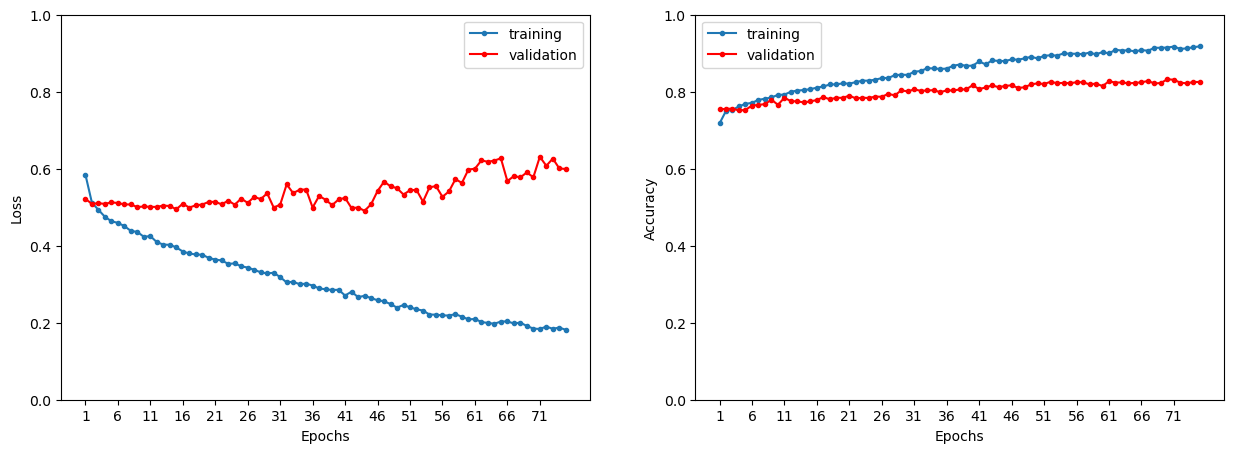

In [142]:
epochs = range(1, 76)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["loss"], label="training", marker=".")
plt.plot(epochs, history.history["val_loss"], label="validation", marker=".", color = 'red')
plt.xlabel("Epochs")
plt.yticks()
plt.ylim([0, 1])
plt.xticks(epochs[::5])
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["bi_accuracy"], label="training", marker=".")
plt.plot(epochs, history.history["val_bi_accuracy"], label="validation", marker=".", color = 'red')
plt.xlabel("Epochs")
plt.yticks()
plt.ylim([0, 1])
plt.xticks(epochs[::5])
plt.ylabel("Accuracy")
plt.legend()

plt.show()

As we can see above, our model is overfitting. Let's try to investigate the causes and try to improve our model.

In [143]:
from sklearn.metrics import precision_score

In [144]:
# Function to make hard predictions

def predict_with_threshold(soft_predictions,threshold):
    
    '''
    
    INPUT
    soft_predictions - the output from model.predict, probabilities
    threshold - the probability above which we will classify as neutralized
    
    OUPUT
    hard_prediction - binary array predicting neutralized (1) or not (0)
    
    '''
    
    hard_prediction = (soft_predictions >= threshold).reshape(-1)
    
    
    return hard_prediction

To use predict_with_threshold, we first train our model, then get soft_predictions by running model.predict. Finally, we put soft_predictions and chosen threshold in the predict_with_threshold.



In [145]:
# Testing the function predict_with_threshold

# Changing the threshold for the predictions
threshold = 0.8 # Specify the desired threshold value
hard_preds = predict_with_threshold(y_pred, threshold)
hard_preds

array([False,  True, False, ..., False,  True, False])

Let's check how our precision changes with the threshold 

In [146]:
# Make precision go up/down by adjusting the threshold


precision_list = []

thresh_range = np.arange(.1,1,.001)

for thresh in thresh_range:
    
    hard_prediction = predict_with_threshold(y_pred, thresh)
    
    true_positive = ((hard_prediction == 1) & (np.array(y_test) == 1)).sum()
    
    false_positive = ((hard_prediction == 1) & (np.array(y_test) == 0)).sum()
    
    precision_ = true_positive/(true_positive + false_positive)
    
    precision_list.append(precision_) 


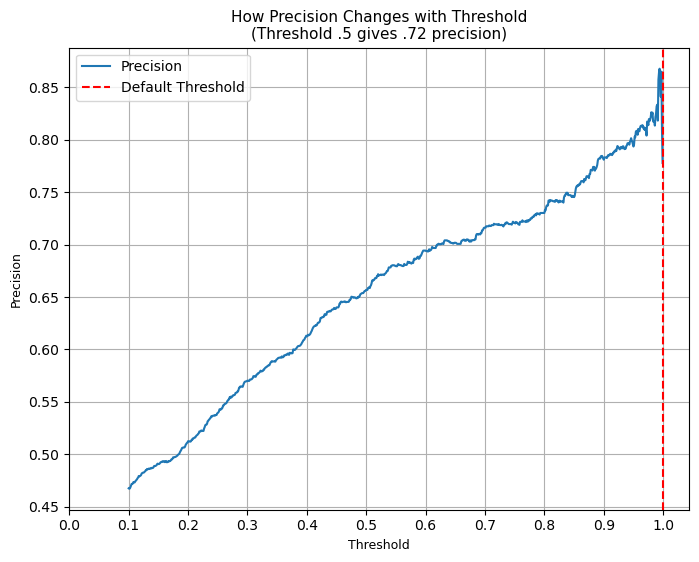

In [147]:
plt.figure(figsize=(8, 6))  # Adjust the figure size

plt.plot(thresh_range, precision_list, label="Precision")  # Add markers with 'o' style
plt.axvline(x=default_threshold, color='r', linestyle='--', label="Default Threshold")
plt.ylabel("Precision", fontsize=9)  # Increase font size of the labels
plt.xlabel("Threshold", fontsize=9)  # Increase font size of the labels
plt.title("How Precision Changes with Threshold\n(Threshold .5 gives .72 precision)", fontsize=11)  # Increase font size of the title
plt.grid(True)  # Add grid lines
plt.xticks(np.arange(0, 1.05, 0.1))  # Adjust x-axis ticks
plt.legend()  # Add legend
plt.show()

With the increase of the threshold, we can see that the precision increases. But if it is close to 1, also is not going to identify neutralizers as non-neutralizers. Between 0.7 and 0.8 is when our precision is high and able to separate classes.

In [148]:
# Counting the number of true positives with the increase of the threshold

true_pos_count = [] 
false_pos_count = []
threshold_ = []

for t in thresh_range:    
    hard_preds = predict_with_threshold(y_pred, t)
    true_positive = ((hard_preds == 1) & (np.array(y_test) == 1)).sum()    
    false_positive = ((hard_preds == 1) & (np.array(y_test) == 0)).sum()  
    
    threshold_.append(t)
    true_pos_count.append(true_positive)
    false_pos_count.append(false_positive)


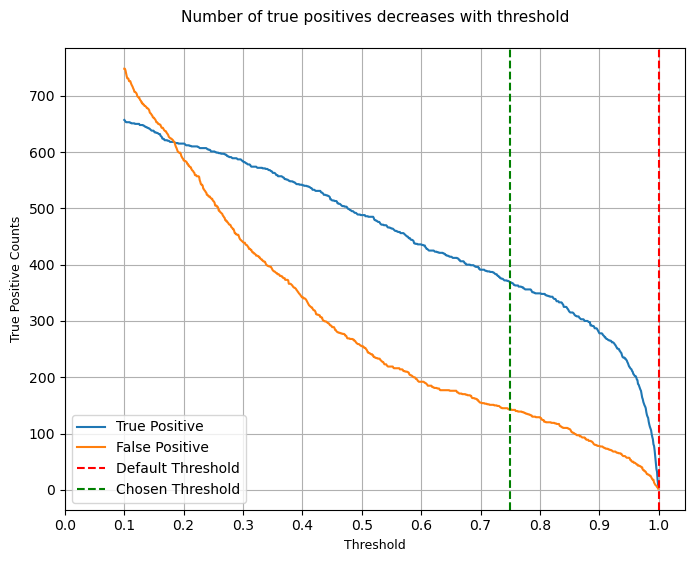

In [149]:
plt.figure(figsize=(8, 6))  # Adjust the figure size

plt.plot(threshold_, true_pos_count, label="True Positive")  # Add markers with '.' style
plt.plot(threshold_, false_pos_count, label="False Positive")  # Add markers with '.' style
plt.axvline(x=default_threshold, color='r', linestyle='--', label="Default Threshold")
plt.axvline(x=0.75, color='g', linestyle='--', label="Chosen Threshold")
plt.ylabel("True Positive Counts", fontsize=9)  # Increase font size of the labels
plt.xlabel("Threshold", fontsize=9)  # Increase font size of the labels
plt.title("Number of true positives decreases with threshold\n ", fontsize=11)  # Increase font size of the title
plt.grid(True)  # Add grid lines
plt.xticks(np.arange(0, 1.05, 0.1))  # Adjust x-axis ticks
plt.legend()  # Add legend

plt.show()

In [150]:
#Confusion matrix for model evaluation using specific threshold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class predictions
y_pred2 = predict_with_threshold(y_pred, 0.75)

# Generate confusion matrix
cf_matrix2 = confusion_matrix(y_test, y_pred2)

# label rows and columns
cf_df2 = pd.DataFrame(
    cf_matrix2, 
    columns=["Predicted Non-Neutralizer", "Predicted Neutralizer"],
    index=["True Non-neutralizer", "True Neutralizer"]
)

display(cf_df2)

,Predicted Non-Neutralizer,Predicted Neutralizer
True Non-neutralizer,2425,143
True Neutralizer,457,369


In [151]:
y_pred2.sum()

512

Precision is now 72% and recall 57%. We are able to classify neutralizers and non-neutralizers.


Because our model now is less conservative to make predictions, we can separate better our classes. With a threshold of 0.75, we can get at least 369 correct predictions for true neutralizers out of 826 true neutralizers.

### Next Steps

Improve precision by testing the model using single antibodies.